In this notebook we inspect the data characteristics of our Allen SDK neural spiking data for the drifting gradient stimulus presentations. In our predictive modeling experiments so far we've seen indications that our models might be suffering from a lack of useful data. Given the number of trials and samples given in the Allen SDK that we're using, a logical explanation for data sparsity in spite of this high volume of data may be sparsity of spikes in the data itself. **In this notebook we will inspect the sparsity of the Allen SDK data we're using in our experiments.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('../pytorch_experiments/binary_spike_matrix_data/all_trial_data_BINNED_715093703_11_30_50.npy', 'rb') as f:
    spikes = np.load(f, allow_pickle=True)

In [3]:
spikes.shape

(487, 131, 2001)

## *Question 1: How many distinct 131-vectors are actually present in this data?*

In [93]:
a = np.array([[1, 0, 0, 1],[1, 0, 0, 1],[1, 0, 0, 1],[1, 0, 0, 2]])
a_unq = np.unique(a, axis=0)

In [94]:
a_unq

array([[1, 0, 0, 1],
       [1, 0, 0, 2]])

*Applying np.unique is annoying with a 3d array, just going to flatten it out an do it this way:*

In [95]:
spikes_reshaped = np.transpose(spikes, (0,2,1))

In [96]:
spikes_reshaped.shape

(487, 2001, 131)

In [97]:
spikes_reshaped = np.reshape(spikes_reshaped, (487*2001, 131))

In [98]:
spikes_reshaped.shape

(974487, 131)

In [99]:
unique_spikes = np.unique(spikes_reshaped, axis=0)

In [100]:
unique_spikes.shape

(113883, 131)

**Answer: There are 113883 distinct 131-vectors in the dataset. This is $\approx 11.7\%$ of the data. Moral: our dataset is effectively a tenth the size we think it is.**

## *Question 2: What is the average/distribution of the lengths of zero-blocks in the data (across all trials)?*

Here, a "zero-block" is any stretch of time-slice vectors the is all-zero. For this question a zero-block can be of length $\geq 1$.

In [101]:
# for simpler indexing going to put the data dimension on the outside
# -> reshaping into (trial, sequence, dimension) form (i.e. "tsd")
spikes_tsd = np.transpose(spikes, (0,2,1))
print(spikes_tsd.shape)

(487, 2001, 131)


In [102]:
zero_block_lens = {}

curr_block_len = 0
for trial in range(spikes_tsd.shape[0]):
    for time in range(spikes_tsd.shape[1]):
        # when we see a zero vector, accumulate the counter
        if (spikes_tsd[trial,time] == np.zeros((131,))).all():
            curr_block_len += 1
        # when we don't, check how long the stretch of zeros before was
        else:
            if curr_block_len > 0:
                if curr_block_len in zero_block_lens.keys():
                    zero_block_lens[curr_block_len] += 1
                else:
                    zero_block_lens[curr_block_len] = 1
                curr_block_len = 0

In [103]:
zero_block_lens

{1: 133694,
 2: 38221,
 3: 12051,
 4: 4090,
 5: 1568,
 6: 667,
 7: 298,
 8: 159,
 11: 39,
 9: 92,
 12: 21,
 14: 8,
 13: 16,
 10: 59,
 16: 8,
 18: 2,
 15: 6,
 21: 1,
 32: 1,
 17: 1}

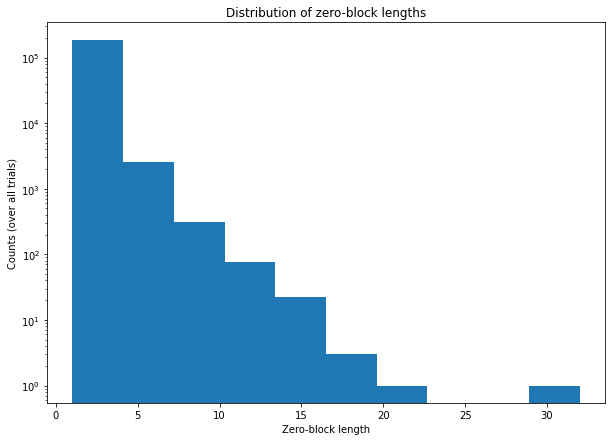

In [104]:
val, weight = zip(*[(k, v) for k,v in zero_block_lens.items()])
plt.figure(figsize=(10,7))
plt.hist(val, weights=weight)
plt.yscale('log')
plt.xlabel('Zero-block length')
plt.ylabel('Counts (over all trials)')
plt.title('Distribution of zero-block lengths')
plt.show()

*... and the total number of zero-vectors in the data: 280592 out of 974487 total vectors (28.8%)*

In [105]:
total_zero_vecs = sum([num*leng for (leng, num) in zero_block_lens.items()])
total_zero_vecs

280592

***... and the average zero-block length is:***

In [106]:
num_zero_blocks = sum([num for (_, num) in zero_block_lens.items()])
average_zero_block_len = total_zero_vecs/num_zero_blocks
print(average_zero_block_len)

1.4690526800766484


***... and if we define a zero-block to be of length at least 2:***

In [107]:
zero_block_lens_geq2 = zero_block_lens.copy()
zero_block_lens_geq2.pop(1)

avg_zblock_geq2 = sum([num*leng for (leng, num) in zero_block_lens_geq2.items()])\
                    /sum([num for (_, num) in zero_block_lens_geq2.items()])

print(avg_zblock_geq2)

2.563307042646751


### *Bonus question, what's the distribution of interspike times for these neurons*

In [79]:
spikes[0,0].shape

(2001,)

In [83]:
interspike_times = {}

curr_ist = 0
for trial in range(spikes.shape[0]):
    for nrn in range(spikes.shape[1]):
        for time in range(spikes.shape[2]):
            if spikes[trial,nrn,time] == 0:
                curr_ist += 1
            else:
                if curr_ist > 0:
                    if curr_ist in interspike_times.keys():
                        interspike_times[curr_ist] += 1
                    else:
                        interspike_times[curr_ist] = 1
                    curr_ist = 0

In [1]:
# interspike_times

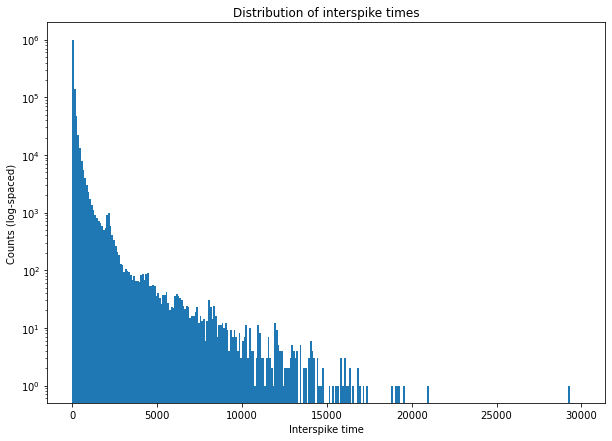

In [99]:
val, weight = zip(*[(k, v) for k,v in interspike_times.items()])
plt.figure(figsize=(10,7))
plt.hist(val, bins=np.arange(start=0, stop=30000, step=100), weights=weight)
plt.yscale('log')
plt.xlabel('Interspike time')
plt.ylabel('Counts (log-spaced)')
plt.title('Distribution of interspike times')
plt.show()

## *Question 3: What's average number/distribution of zero-blocks per trial*

Here we'll define a zero-block to be of length at least 2 (because we saw how many more single zero-vectors there are)

In [109]:
# the number of zero-blocks will be stored along with the corresponding trial number
zero_blocks_per_trial = {}

num_blocks_in_trial = 0
curr_block_len = 0
for trial in range(spikes_tsd.shape[0]):
    for time in range(spikes_tsd.shape[1]):
        if (spikes_tsd[trial,time] == np.zeros((131,))).all():
            curr_block_len += 1
        else:
            if curr_block_len > 1:
                num_blocks_in_trial += 1
                curr_block_len = 0
    zero_blocks_per_trial[trial] = num_blocks_in_trial
    num_blocks_in_trial = 0

In [2]:
# zero_blocks_per_trial

***distribution across trials***

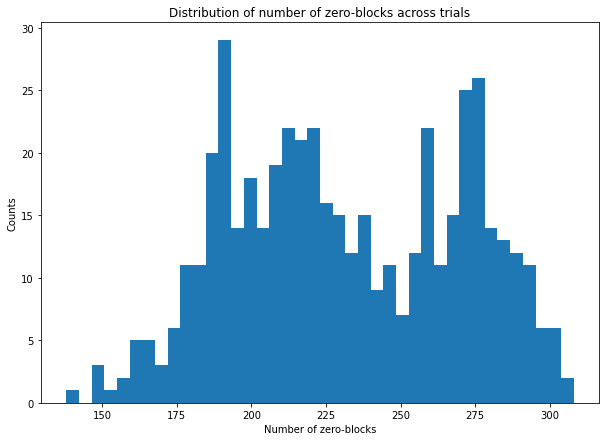

In [111]:
plt.figure(figsize=(10,7))
plt.hist(zero_blocks_per_trial.values(),bins=40)
plt.xlabel('Number of zero-blocks')
plt.ylabel('Counts')
plt.title('Distribution of number of zero-blocks across trials')
plt.show()

***Average number across all trials***

In [112]:
np.mean(list(zero_blocks_per_trial.values()))

231.72484599589322

## Getting per-channel interspike time plots

To further investigate the claim that our data does not have sufficient dynamical information in it to be successfully learned by our RNN, we'll check whether our interspike times are exponentially distributed.

1) Want list of interspike times for each channel

In [4]:
# this list will contain 131 lists of interspike times for each channel
interspike_times = []

curr_ist = 0
for nrn in range(spikes.shape[1]):
    # list for this specific neuron's ISTs
    nrn_ists = []
    for trial in range(spikes.shape[0]):
        curr_ist = 0
        for time in range(spikes.shape[2]):
            if spikes[trial,nrn,time] == 0:
                curr_ist += 1
            else:
                if curr_ist > 0:
                    nrn_ists.append(curr_ist)
                    curr_ist = 0
    interspike_times.append(nrn_ists)

2) For each channel, want the (x,y) plotting coordinates – these will be given by the (bin, count) histogram values for each neuron's IST list

In [5]:
# np.histogram gives us the (x,y) tuple of x and y coordinate lists for a given
# neuron's histogram
IST_coordinates = []

for nrn in range(len(interspike_times)):
    hist_points = np.histogram(interspike_times[nrn],bins=100)
    # the numpy hist method gives us the bounds on the histogram bins
    # so we'll calculate the list of midpoints
    bin_middles = [(hist_points[1][i] + hist_points[1][i+1])/2 for i in range(len(hist_points[1]) - 1)]
    IST_coordinates.append((bin_middles, hist_points[0]))

3) Want to normalize all these curves so they peak at 1 and have their y=0.5 point at the same x value

In [6]:
# going to store the normalized curves in a different list
normalized_ISTs = []

for (xs, ys) in IST_coordinates:
    y_max = max(ys)
    # for each curve, want to first normalize the y values
    normalized_ys = ys/y_max
    # then we scale the x axis by the x value where we reach y=1/2
    # --> want to iterate over the xs and store the last index where y>1/2
    for i in range(len(xs)):
        if normalized_ys[i] < 0.5:
            x_half = xs[i-1]
            break
    normalized_xs = xs/x_half
    normalized_ISTs.append((normalized_xs, normalized_ys))

4) Plot them all against each other

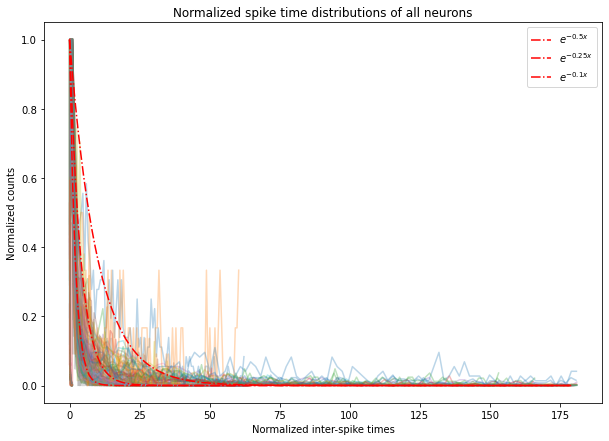

In [8]:
plt.figure(figsize=(10,7))

for (xs,ys) in normalized_ISTs:
        plt.plot(xs, ys, alpha=0.3)

plt.plot(np.arange(180), [np.e**(-0.5*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.5x}$')
plt.plot(np.arange(180), [np.e**(-0.25*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.25x}$')
plt.plot(np.arange(180), [np.e**(-0.1*x) for x in np.arange(180)], color='red', linestyle='-.', label=r'$e^{-0.1x}$')

plt.xlabel('Normalized inter-spike times')
plt.ylabel('Normalized counts')
# plt.yscale('log')
plt.title('Normalized spike time distributions of all neurons')
plt.legend()
plt.savefig('../../Summer/Data 2050/Practicum report/figures/empirical_data_ist_distribution', dpi=300)
plt.show()